In [1]:
import pandas as pd
import numpy as np 
import re
import string
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    

In [4]:
data = pd.read_csv('../data/data_F.csv', sep=';') # lecture data set 
department = np.copy(data['zip_code'].values)

In [5]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if not embeded_words[word].endswith('_i'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_variance(sentence_embedding, eval_type='var'):
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result

def compute_moyenne(sentence_embedding):
    result = []
    #print(len(sentence_embedding[0]))
    for index in range(len(sentence_embedding[0])): # taille 700
        result.append(np.sum(sentence_embedding[:,index])/len(sentence_embedding))
    return result

In [6]:
scores = []
for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        # score de taille 700
        scores.append(compute_moyenne(answer))#,compute_variance(answer, eval_type='var'),compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan]*700)
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns = ['score_'+str(i) for i in range(700)]) 
argumentation_scores = pd.concat([data['annotation'],scores_df], axis=1) 
argumentation_scores.head(2)

100%|██████████| 2445/2445 [01:10<00:00, 34.93it/s]


,annotation,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,...,score_690,score_691,score_692,score_693,score_694,score_695,score_696,score_697,score_698,score_699
0,1.0,0.002184,-0.015336,-0.015614,0.004679,0.032181,0.061739,-0.052617,0.034983,-0.054036,...,0.029986,0.039820,-0.003342,0.030171,-0.050199,0.039690,-0.009338,-0.014119,0.052214,-0.037971
1,1.0,0.063287,-0.016981,0.022253,-0.004149,0.041670,0.072220,-0.055472,0.000335,-0.045204,...,0.010781,0.019873,-0.005545,-0.014305,-0.030772,0.017193,0.039085,0.000324,0.008392,-0.034817


In [7]:
argumentation_scores = argumentation_scores.dropna()
print(argumentation_scores.shape)
X = argumentation_scores.drop('annotation',axis=1)
Y = argumentation_scores['annotation']
X.head(2)
Y.head(2)

(2445, 701)


0    1.0
1    1.0
Name: annotation, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
freq_1 = y_train.mean()

### Unbalanced weights

In [11]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9)
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1223  206]
 [ 112  415]]
             precision    recall  f1-score   support

        0.0       0.92      0.86      0.88      1429
        1.0       0.67      0.79      0.72       527

avg / total       0.85      0.84      0.84      1956

1956 621.0
0.7229965156794425
---------------Scores on test---------------
[[288  64]
 [ 85  52]]
             precision    recall  f1-score   support

        0.0       0.77      0.82      0.79       352
        1.0       0.45      0.38      0.41       137

avg / total       0.68      0.70      0.69       489

489 137.0
0.4110671936758893


### Default Balanced weights

In [12]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=5, class_weight='balanced')
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1003   74]
 [ 332  547]]
             precision    recall  f1-score   support

        0.0       0.75      0.93      0.83      1077
        1.0       0.88      0.62      0.73       879

avg / total       0.81      0.79      0.79      1956

1956 621.0
0.7293333333333333
---------------Scores on test---------------
[[222 130]
 [ 41  96]]
             precision    recall  f1-score   support

        0.0       0.84      0.63      0.72       352
        1.0       0.42      0.70      0.53       137

avg / total       0.73      0.65      0.67       489

489 137.0
0.5289256198347108


### Custom Balanced weights

In [13]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9, class_weight= {0:freq_1, 1:1-freq_1})
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[989  80]
 [346 541]]
             precision    recall  f1-score   support

        0.0       0.74      0.93      0.82      1069
        1.0       0.87      0.61      0.72       887

avg / total       0.80      0.78      0.78      1956

1956 621.0
0.7175066312997348
---------------Scores on test---------------
[[218 134]
 [ 43  94]]
             precision    recall  f1-score   support

        0.0       0.84      0.62      0.71       352
        1.0       0.41      0.69      0.52       137

avg / total       0.72      0.64      0.66       489

489 137.0
0.5150684931506849


### Dimensionality reduction 

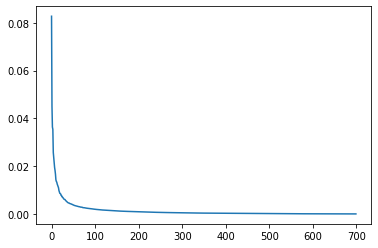

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=700)
pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)


In [15]:
pca = PCA(n_components=313)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 

In [16]:
from sklearn.svm import SVC

svclassifier = SVC(kernel='linear', C=6.03e-01, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[866 100]
 [469 521]]
             precision    recall  f1-score   support

        0.0       0.65      0.90      0.75       966
        1.0       0.84      0.53      0.65       990

avg / total       0.74      0.71      0.70      1956

1956 621.0
0.6468032278088144
---------------Scores on test---------------
[[217 135]
 [ 26 111]]
             precision    recall  f1-score   support

        0.0       0.89      0.62      0.73       352
        1.0       0.45      0.81      0.58       137

avg / total       0.77      0.67      0.69       489

489 137.0
0.5796344647519583


### Cross Validation 

In [17]:
from tqdm import trange
n_split = 1
n_val = 800
cv_parameters = {'log_10_C': [-1, 2],
                 'n_comp':[10, 400] }
scores = []
log_10_cs = []
n_comps = []

progress_bar = trange(n_val, desc='Bar desc', leave=True)
for n in progress_bar:
    log_10_c = np.random.random() * (cv_parameters['log_10_C'][1] - cv_parameters['log_10_C'][0]) + cv_parameters['log_10_C'][0]
    n_comp = int(np.random.random() * (cv_parameters['n_comp'][1] - cv_parameters['n_comp'][0]) + cv_parameters['n_comp'][0])
    n_comps.append(n_comp)
    log_10_cs.append(log_10_c)
    f1_mean = []
    for split in range(n_split): 
        
        X_cv_train, X_val, y_cv_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=split)
        
        pca = PCA(n_components=n_comp)
        
        pca.fit_transform(X_train)
        X_train_pca = pca.transform(X_cv_train)
        X_test_pca = pca.transform(X_val)
        
        svclassifier = SVC(kernel='linear', C=10**log_10_c, class_weight= 'balanced')
        svclassifier.fit(X_train_pca, y_cv_train)
        
        y_pred = svclassifier.predict(X_test_pca)
        f1_mean.append(f1_score(y_pred,y_val))
    scores.append(np.mean(f1_mean))
    i_max = scores.index(max(scores))
    progress_bar.set_description('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))
    progress_bar.refresh()
    
        
i_max = scores.index(max(scores))
print('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))


best f1 : 5.98e-01 |  for C = 8.71e-01 with 274 components:  12%|█▏        | 95/800 [20:08<2:38:11, 13.46s/it]

KeyboardInterrupt: 

### PCA on all dataset

In [9]:
data_unnanotated = pd.read_csv('../data/dataset_1.csv') # lecture data set 
print(data_unnanotated)

       Unnamed: 0  zip_code  \
0               1     57000   
1               5     95330   
2               6     84750   
3              10     33820   
4              14      8500   
...           ...       ...   
15304       35973     33320   
15305       35974     17430   
15306       35975     38340   
15307       35978     75017   
15308       35981     78180   

                                                 problem  \
0      Les problèmes auxquels se trouve confronté l’e...   
1                                  La pollution de l'air   
2      La biodiversité et la disparition de certaines...   
3                                  La pollution de l'air   
4                                  Pollution air et mers   
...                                                  ...   
15304  La pollution du sol !!!! et les déreglements c...   
15305  Tous les problèmes évoqués ci dessus sont impo...   
15306                             Agriculture raisonnée.   
15307  Tout est lié. Il fau

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


143.01104593276978
---------------Scores on train---------------
[[806 114]
 [529 507]]
              precision    recall  f1-score   support

         0.0       0.60      0.88      0.71       920
         1.0       0.82      0.49      0.61      1036

    accuracy                           0.67      1956
   macro avg       0.71      0.68      0.66      1956
weighted avg       0.72      0.67      0.66      1956

1956 621.0
0.611949305974653
---------------Scores on test---------------
[[214 138]
 [ 25 112]]
              precision    recall  f1-score   support

         0.0       0.90      0.61      0.72       352
         1.0       0.45      0.82      0.58       137

    accuracy                           0.67       489
   macro avg       0.67      0.71      0.65       489
weighted avg       0.77      0.67      0.68       489

489 137.0
0.5788113695090439


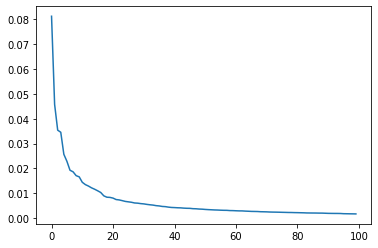

In [10]:
import time 
from sklearn.decomposition import PCA
from sklearn.svm import SVC

start = time.time()
unnanotated_embeded_data = data_unnanotated.head(10000)['solution'].map(lambda x : np.mean(embed_answer(x).reshape(-1,700),axis=0))
print(time.time()-start)
x = pd.DataFrame(np.asarray(unnanotated_embeded_data.tolist()).astype(np.float64))
x = x.dropna()

pca = PCA(n_components=100)
pca.fit_transform(x)
plt.plot(pca.explained_variance_ratio_)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


svclassifier = SVC(kernel='linear', C=6.03e-01, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

In [12]:
x

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
0,0.002184,-0.015336,-0.015614,0.004679,0.032181,0.061739,-0.052617,0.034983,-0.054036,-0.003560,...,0.029986,0.039820,-0.003342,0.030171,-0.050199,0.039690,-0.009338,-0.014119,0.052214,-0.037971
1,0.063287,-0.016981,0.022253,-0.004149,0.041670,0.072220,-0.055472,0.000335,-0.045204,-0.055905,...,0.010781,0.019873,-0.005545,-0.014305,-0.030772,0.017193,0.039085,0.000324,0.008392,-0.034817
2,0.062479,-0.016062,0.022250,-0.007306,0.061340,0.070155,-0.063448,0.031735,-0.137925,-0.039277,...,0.010198,0.011956,-0.021904,0.014571,-0.027251,0.023213,0.028321,0.043685,-0.010480,-0.013711
3,0.136225,-0.093007,0.003619,0.026869,0.057067,0.102000,-0.123075,0.012990,-0.082796,0.005155,...,0.088216,-0.011502,-0.079337,0.027293,-0.071953,-0.053504,-0.034882,0.111229,0.024426,-0.039842
4,0.037710,-0.054166,0.011200,-0.036107,-0.003270,0.021288,-0.063551,-0.018885,-0.050624,-0.046092,...,0.010539,0.062242,-0.013465,0.043487,-0.030116,0.037946,-0.004833,-0.031555,-0.021488,-0.015373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.089842,-0.040097,0.020616,-0.005462,0.010568,0.092909,-0.125005,-0.028189,-0.060241,0.013895,...,0.027672,0.020746,-0.003435,0.028500,-0.067110,0.024450,-0.018964,0.018985,0.089217,-0.035829
9996,0.006115,-0.061070,0.009837,0.100736,0.066516,0.078720,-0.003110,0.006226,-0.137662,-0.056973,...,0.069259,-0.000112,0.021560,0.046167,0.006225,0.034045,-0.039023,-0.052483,-0.058278,-0.083566
9997,0.026768,-0.068465,0.010195,0.043594,0.012357,0.036338,-0.079806,0.081475,-0.143029,-0.018811,...,0.025200,0.000981,-0.020194,0.034696,0.010648,0.030673,0.038642,0.057085,-0.015951,-0.081557
9998,0.037156,-0.021300,0.036185,0.021649,0.005418,0.079225,-0.093102,-0.003418,-0.036865,0.005058,...,0.018532,0.083901,0.000828,0.003613,-0.058665,0.092574,-0.002797,-0.006725,0.093256,-0.020089


In [14]:
#x['pred'] = svclassifier.predict(pca.transform(x.drop('Department',axis=1)))
x['pred'] = svclassifier.predict(pca.transform(x))

In [15]:
x['Department'] = data_unnanotated['zip_code'] // 1000

In [16]:
x.head(5)

,0,1,2,3,4,5,6,7,8,9,...,692,693,694,695,696,697,698,699,pred,Department
0,0.002184,-0.015336,-0.015614,0.004679,0.032181,0.061739,-0.052617,0.034983,-0.054036,-0.003560,...,-0.003342,0.030171,-0.050199,0.039690,-0.009338,-0.014119,0.052214,-0.037971,1.0,57
1,0.063287,-0.016981,0.022253,-0.004149,0.041670,0.072220,-0.055472,0.000335,-0.045204,-0.055905,...,-0.005545,-0.014305,-0.030772,0.017193,0.039085,0.000324,0.008392,-0.034817,1.0,95
2,0.062479,-0.016062,0.022250,-0.007306,0.061340,0.070155,-0.063448,0.031735,-0.137925,-0.039277,...,-0.021904,0.014571,-0.027251,0.023213,0.028321,0.043685,-0.010480,-0.013711,1.0,84
3,0.136225,-0.093007,0.003619,0.026869,0.057067,0.102000,-0.123075,0.012990,-0.082796,0.005155,...,-0.079337,0.027293,-0.071953,-0.053504,-0.034882,0.111229,0.024426,-0.039842,0.0,33
4,0.037710,-0.054166,0.011200,-0.036107,-0.003270,0.021288,-0.063551,-0.018885,-0.050624,-0.046092,...,-0.013465,0.043487,-0.030116,0.037946,-0.004833,-0.031555,-0.021488,-0.015373,1.0,8


In [17]:
unique_dpt = np.unique(x['Department'], return_counts=True)[0]
mapping = {'pred':{}}

for eval_type in mapping.keys():
    for dpt in unique_dpt:
        values = x[x['Department']==dpt][eval_type].dropna().values
        try:
            percentile = np.percentile(abs(values),95)
            valid_values = values[abs(values)<=percentile]

            M = np.mean(valid_values)
            V = np.var(valid_values)
        except:
            M, V = np.nan, np.nan

        mapping[eval_type][dpt] = [M,V]
    
    
    # May need to add this to the dataframe... Then, uncomment the code below
    #try:
    #    final_data = final_data.drop(eval_type + '_mean_wrt_dpt', axis=1)
    #except:
    #    pass
    #means = []
    #for index in final_data.index:
    #    means.append(mapping[eval_type][final_data['Department'][index]][0])

    #means = pd.DataFrame(means, index=final_data.index, columns=[eval_type + '_mean_wrt_dpt'])
    #final_data = pd.concat([final_data, means], axis=1)

In [76]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
pd.options.mode.chained_assignment = None  # default='warn'

def plot_cartography(Colors, eval_type, figsize=(10, 6)):
    # set the filepath and load in a shapefile
    fp = '../data/departements-20180101-shp/departements-20180101.shp'
    map_df = gpd.read_file(fp)
    # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
    merged = map_df.set_index('code_insee').join(Colors.set_index('code_insee'))
    merged['colors']['2A'] = merged['colors']['2B'] = Colors['colors'][20]
    merged['colors']['69D'] = merged['colors']['69M'] = Colors['colors'][69]
    for idx in merged.index:
        if idx not in Colors['code_insee'].values and idx!='2A' and idx!='2B' and idx!='69D' and idx!='69M':
            merged = merged.drop(index=idx)
    merged.head()

    # set a variable that will call whatever column we want to visualise on the map
    variable = 'colors'
    # set the range for the choropleth
    vmin, vmax = np.min(merged[variable].values)-1e-5, np.max(merged[variable].values)
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=figsize)

    # create map
    merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

    ax.axis('off')

    ax.set_title("French Departments, colors correpond to the mean of the argumentation scores : " + eval_type,
                 fontdict={'fontsize': '10', 'fontweight' : '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)

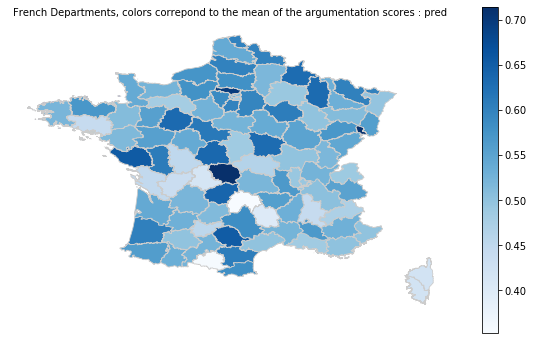

In [19]:
dpts = [k for k in range(1,96)]
for eval_type in ['pred']:
    Colors = []
    for dpt in dpts:
        Colors.append(mapping[eval_type][dpt][0]) # Because in the geopandas the departments go from 0 to 94

    Colors = pd.DataFrame(Colors, index=dpts, columns=['colors'])
    Colors = pd.concat([Colors, pd.DataFrame(['0'+str(k) for k in range(1,10)] + [str(k) for k in range(10,96)],
                                             index=dpts, columns=['code_insee'])], axis=1)

    plot_cartography(Colors, eval_type, figsize=(10,6))
    plt.savefig('../../{}.png'.format(eval_type))

### Let's couple both scores of Quality and Diversity !

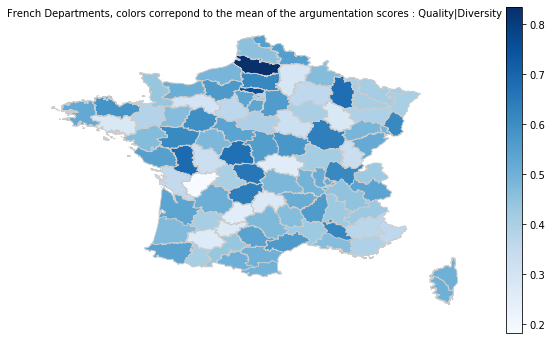

In [77]:
diversity = pd.read_csv('../scores_df.csv',sep=',').drop('Unnamed: 0',axis=1)

unique_dpt = np.unique(diversity['Department'], return_counts=True)[0]
mapping = {'qual_div':{}}

M_quals = []
M_divs = []

for dpt in unique_dpt:
    qual = x[x['Department']==dpt]['pred'].dropna().values
    div = diversity[diversity['Department']==dpt]['Variance'].dropna().values

    M_qual = np.mean(qual)
    #V_qual = np.var(qual)

    #low_percentile_div = np.percentile(div,2.5)
    #high_percentile_div = np.percentile(div,97.5)
    #valid_values_div = div[div<=high_percentile_div]
    #valid_values_div = valid_values_div[valid_values_div>=low_percentile_div]
    

    M_div = np.median(div)
    #V_div = np.var(valid_values_div)

    M_quals.append(M_qual)
    M_divs.append(M_div)
    
M_quals = np.array(M_quals)
M_divs = np.array(M_divs)
    
M_quals = (M_quals - np.min(M_quals))/(np.max(M_quals) - np.min(M_quals))
M_divs = (M_divs - np.min(M_divs))/(np.max(M_divs) - np.min(M_divs))

for dpt in range(len(M_divs)):
    mapping['qual_div'][dpt+1] = (M_quals[dpt] + M_divs[dpt])/2
    
dpts = [k for k in range(1,96)]
Colors = []
for dpt in dpts:
    Colors.append(mapping['qual_div'][dpt]) # Because in the geopandas the departments go from 0 to 94

Colors = pd.DataFrame(Colors, index=dpts, columns=['colors'])
Colors = pd.concat([Colors, pd.DataFrame(['0'+str(k) for k in range(1,10)] + [str(k) for k in range(10,96)],
                                         index=dpts, columns=['code_insee'])], axis=1)

plot_cartography(Colors, eval_type, figsize=(10,6))
plt.savefig('../../qual_div.png')

### logistic regression

In [18]:
pca = PCA(n_components=500)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 


from sklearn.linear_model import LogisticRegression 
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          multi_class='ovr', C=100.0,
                        class_weight='balanced')

clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))



---------------Scores on train---------------
[[1073   88]
 [ 262  533]]
             precision    recall  f1-score   support

        0.0       0.80      0.92      0.86      1161
        1.0       0.86      0.67      0.75       795

avg / total       0.83      0.82      0.82      1956

1956 621.0
0.7528248587570622
---------------Scores on test---------------
[[241 111]
 [ 56  81]]
             precision    recall  f1-score   support

        0.0       0.81      0.68      0.74       352
        1.0       0.42      0.59      0.49       137

avg / total       0.70      0.66      0.67       489

489 137.0
0.49240121580547114


In [19]:
pca = PCA(n_components=30)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 


from sklearn.ensemble import RandomForestClassifier 


clf = RandomForestClassifier(n_estimators=190, max_depth=6, class_weight='balanced')
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


---------------Scores on train---------------
[[1058   63]
 [ 277  558]]
             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86      1121
        1.0       0.90      0.67      0.77       835

avg / total       0.84      0.83      0.82      1956

1956 621.0
0.7664835164835165
---------------Scores on test---------------
[[256  96]
 [ 45  92]]
             precision    recall  f1-score   support

        0.0       0.85      0.73      0.78       352
        1.0       0.49      0.67      0.57       137

avg / total       0.75      0.71      0.72       489

489 137.0
0.5661538461538461


In [20]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=clf)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = clf.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1282    0]
 [  53  621]]
             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98      1282
        1.0       1.00      0.92      0.96       674

avg / total       0.97      0.97      0.97      1956

1956 621.0
0.959073359073359
---------------Scores on test---------------
[[293  59]
 [ 62  75]]
             precision    recall  f1-score   support

        0.0       0.83      0.83      0.83       352
        1.0       0.56      0.55      0.55       137

avg / total       0.75      0.75      0.75       489

489 137.0
0.5535055350553505
